ARIMAX Implementation on Appliances Consumption Data

In [1]:
#All required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import statsmodels.api as sm
import itertools


from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error 

In [2]:
!pip install statsmodels==0.13.2

import pandas as pd
from pandas import datetime

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.5
    Uninstalling statsmodels-0.13.5:
      Successfully uninstalled statsmodels-0.13.5


<ipython-input-2-c89b9f55693e>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
# Load appliances cosumption data from uci machine leanring repository

Appliance_Consumption= pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')

In [4]:
# Data set has large number of features along with consumption So individual features analysis needs to be made whether or not it will be useful for multivariate analysis.
Appliance_Consumption.shape

(19735, 29)

In [5]:
# Convert the date column to a datetime data type
Appliance_Consumption['date'] = pd.to_datetime(Appliance_Consumption['date'])

# Set the index of the DataFrame as the date column
Appliance_Consumption.set_index('date', inplace=True)

In [6]:
Appliance_Consumption.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [7]:
# Since there are lot of columns to kickstart the feature engineering process lets first understand the corelation of appliances consumption with all other columns in the datset

corr_matrix = Appliance_Consumption.corr()['Appliances']

corr_matrix

Appliances     1.000000
lights         0.197278
T1             0.055447
RH_1           0.086031
T2             0.120073
RH_2          -0.060465
T3             0.085060
RH_3           0.036292
T4             0.040281
RH_4           0.016965
T5             0.019760
RH_5           0.006955
T6             0.117638
RH_6          -0.083178
T7             0.025801
RH_7          -0.055642
T8             0.039572
RH_8          -0.094039
T9             0.010010
RH_9          -0.051462
T_out          0.099155
Press_mm_hg   -0.034885
RH_out        -0.152282
Windspeed      0.087122
Visibility     0.000230
Tdewpoint      0.015353
rv1           -0.011145
rv2           -0.011145
Name: Appliances, dtype: float64

In [8]:
# effective columns based on domain
effective_columns=['Appliances','lights', 'T1', 'RH_1' , 'T2' , 'RH_2' , 'T4', 'RH_4' ,'RH_5', 'T6' ,'RH_6','T8','RH_8','T9','RH_9','T_out' ]
len(effective_columns)

16

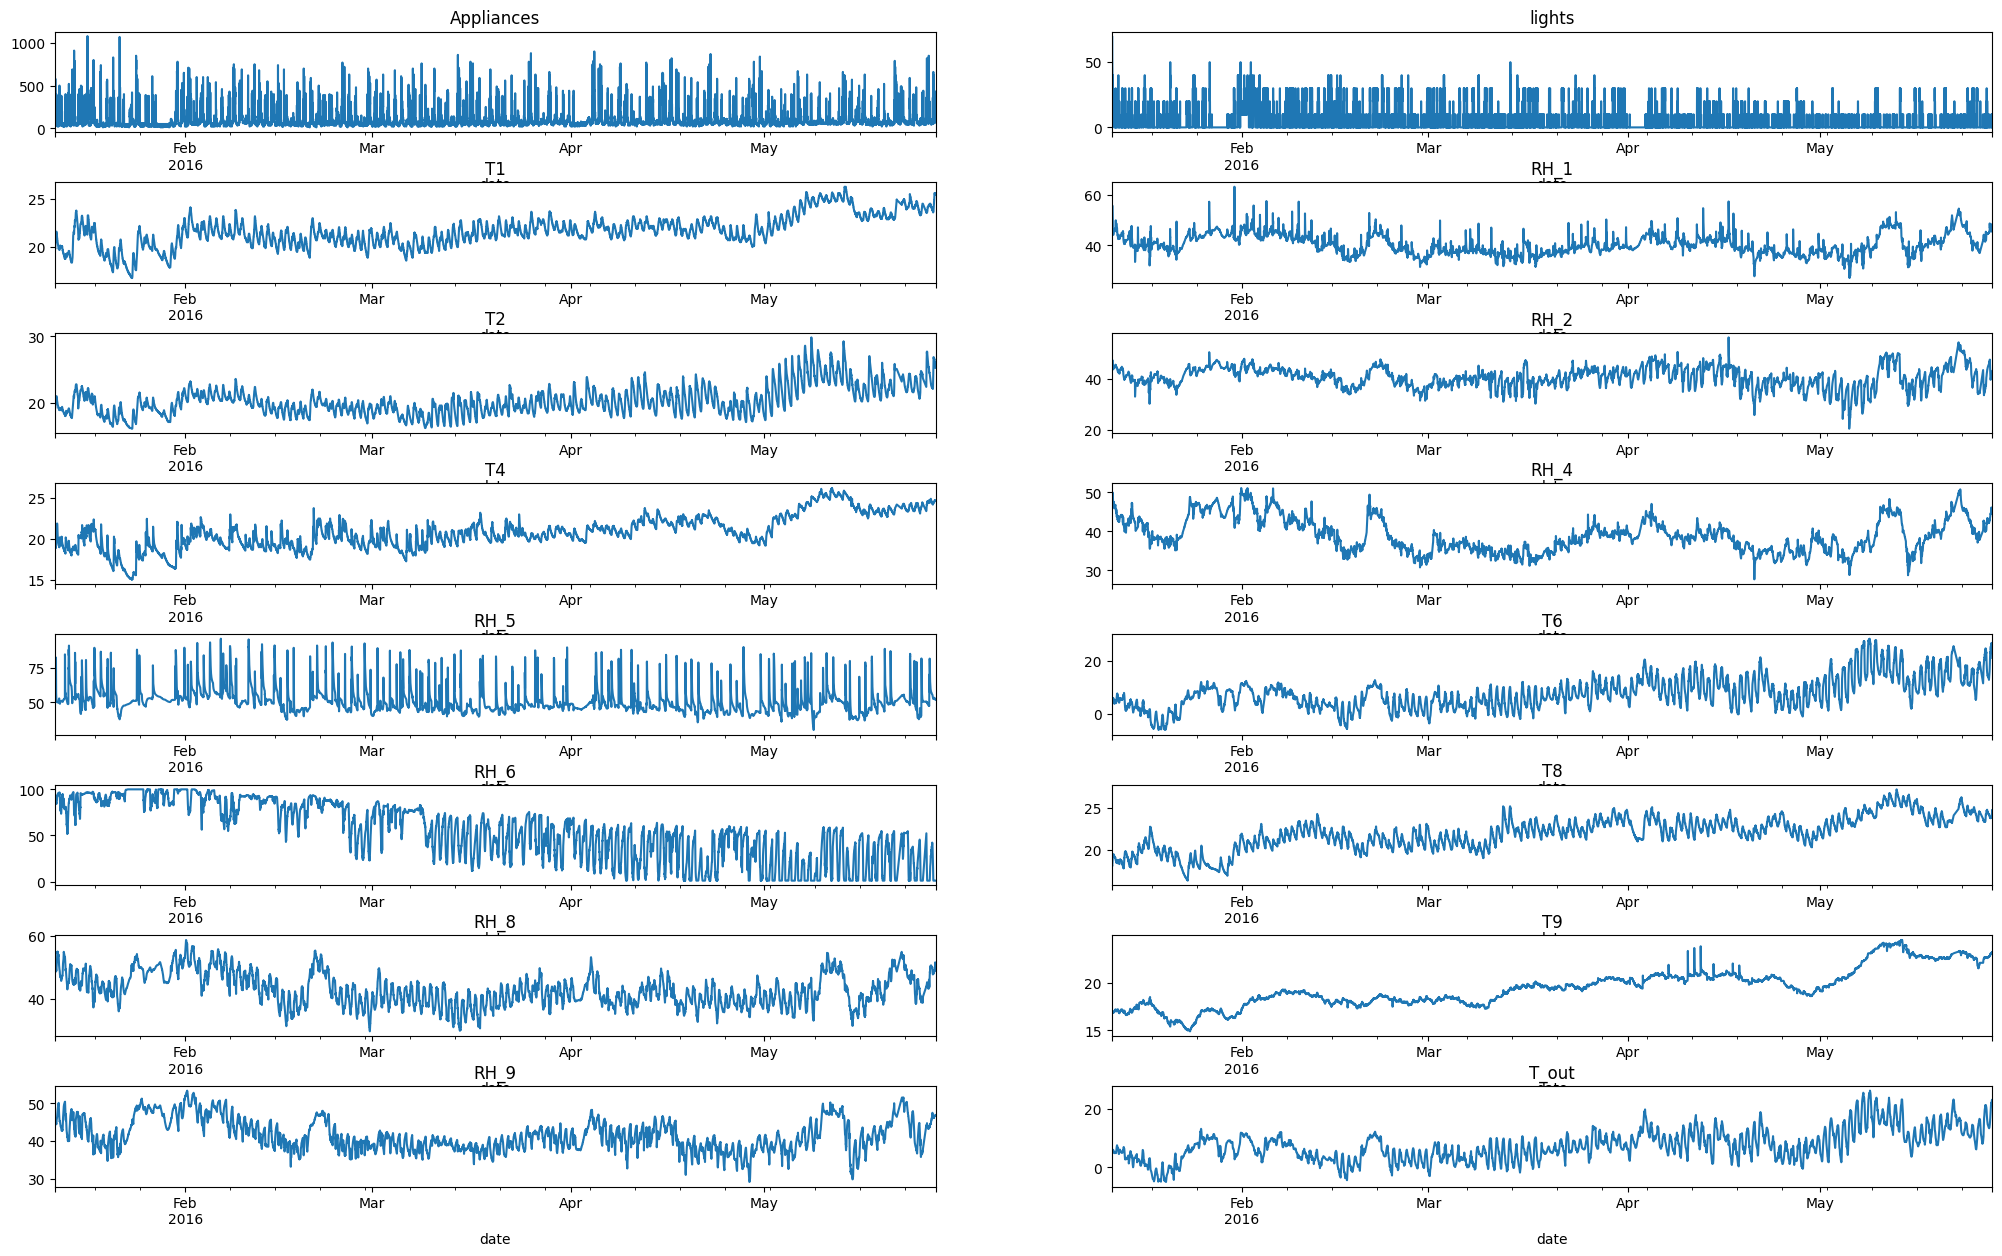

In [9]:
# checking the distributions for effective  columns 

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(25, 15))
axe=axes.ravel()

for i, col in enumerate(effective_columns):
    Appliance_Consumption[col].plot(ax=axe[i])
    axe[i].set_title(col)
    
fig.subplots_adjust(hspace=0.5)

<Axes: xlabel='date'>

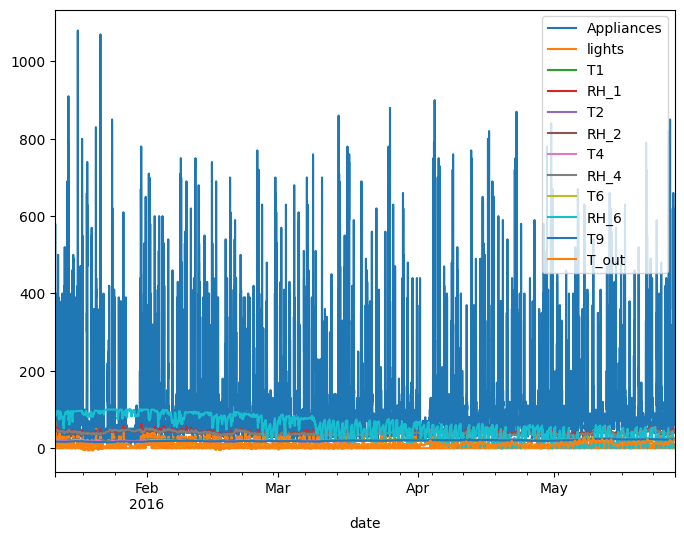

In [10]:
Appliance_Consumption.plot(y=['Appliances','lights', 'T1', 'RH_1' , 'T2' , 'RH_2' , 'T4', 'RH_4' , 'T6' , 'RH_6','T9','T_out' ], figsize=(8, 6))

In [11]:
# final effective columns
Appliance_Consumption_Filtered=Appliance_Consumption.filter(items=['Appliances','lights', 'T1', 'T2' , 'T6','RH_out' ])

In [12]:
Appliance_Consumption_Filtered.head(5)

,Appliances,lights,T1,T2,T6,RH_out
date,,,,,,
2016-01-11 17:00:00,60,30,19.89,19.2,7.026667,92.0
2016-01-11 17:10:00,60,30,19.89,19.2,6.833333,92.0
2016-01-11 17:20:00,50,30,19.89,19.2,6.560000,92.0
2016-01-11 17:30:00,50,40,19.89,19.2,6.433333,92.0
2016-01-11 17:40:00,60,40,19.89,19.2,6.366667,92.0


In [13]:
# test for stationarity
#Ho: It is non stationary
#H1: It is stationary
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['p-value','#Lags Used']
    print(labels[0]+' : '+str(result[1])) 
    print(labels[1]+' : '+str(result[2]))
    if result[1] <= 0.05:
        print("Data has no unit root and is stationary")
    else:
        print("Data is non-stationary ") 

In [14]:
# since its scaled using min max scaler data is stationary without first order differencing
adfuller_test(Appliance_Consumption_Filtered['Appliances'])

p-value : 0.0
#Lags Used : 11
Data has no unit root and is stationary


In [15]:
# scaling the data
scaler = StandardScaler()
scaler = scaler.fit(Appliance_Consumption_Filtered)
Appliance_Consumption_Scaled = scaler.transform(Appliance_Consumption_Filtered)

In [16]:
# scaling the data seperatley for target to re use it inverse transform final predictions
scaler_target = StandardScaler()
scaler_target = scaler_target.fit(Appliance_Consumption_Filtered['Appliances'].values.reshape((-1,1)))
Appliance_Consumption_target_Scaled = scaler_target.transform(Appliance_Consumption_Filtered['Appliances'].values.reshape((-1,1)))

In [17]:
#train size
train_length=len(Appliance_Consumption_Scaled)*0.95
print(int(train_length))

18748


In [18]:
train = pd.DataFrame(Appliance_Consumption_Scaled[0:18748], columns=['Appliances','lights', 'T1', 'T2' , 'T6','RH_out'])
#train=Appliance_Consumption_Scaled[0:18748]
#test=Appliance_Consumption_Scaled[18748:]
test = pd.DataFrame(Appliance_Consumption_Scaled[18748:], columns=['Appliances','lights', 'T1', 'T2' , 'T6','RH_out'])

In [19]:
len(test)

987

<Axes: >

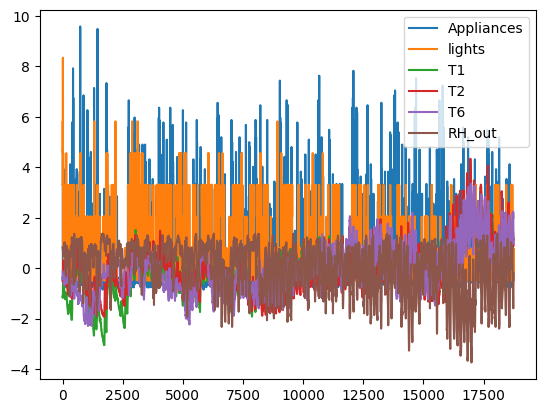

In [20]:
train.plot()

In [21]:
test


,Appliances,lights,T1,T2,T6,RH_out
0,-0.465215,-0.479080,1.083480,0.872254,0.960954,-0.050361
1,-0.367676,-0.479080,1.060649,0.859355,0.928114,0.117416
2,-0.562755,-0.479080,1.060649,0.838509,0.894727,0.285193
3,-0.367676,0.781035,1.060649,0.802028,0.862982,0.307564
4,-0.465215,-0.479080,1.060649,0.783787,0.846562,0.329934
...,...,...,...,...,...,...
982,0.022483,-0.479080,2.415962,2.530318,2.772610,-1.616282
983,-0.075056,-0.479080,2.374452,2.468301,2.674091,-1.593912
984,1.680659,0.781035,2.374452,2.411103,2.580498,-1.571542
985,3.143756,0.781035,2.374452,2.313256,2.384554,-1.549171


In [22]:
# create exog_train and exog_test for model buiding
exog_train = train[['lights', 'T1', 'T2' , 'T6' ,'RH_out' ]]
exog_test=test[['lights', 'T1', 'T2' ,'T6','RH_out' ]]
type(exog_train)

pandas.core.frame.DataFrame

In [23]:

# Define the parameter grid
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Define the function to evaluate the ARIMA model
def evaluate_arima_model(order, data):
    model = sm.tsa.ARIMA(data, order=order, exog=exog_train)
    results = model.fit()
    return results.aic

# Evaluate all the possible combinations of hyperparameters
aic_values = []
for order in pdq:
    try:
        aic = evaluate_arima_model(order, train['Appliances'])
        aic_values.append((order, aic))
    except:
        continue

# Get the hyperparameters with the lowest AIC value
best_order, best_aic = min(aic_values, key=lambda x: x[1])

print(f"The best order is {best_order} with AIC value of {best_aic}")




/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The best order is (2, 0, 2) with AIC value of 36318.33304383215


In [24]:
#ARIMA model building
model_arima = ARIMA(train['Appliances'],order=(2,0,2), exog=exog_train)

In [25]:
model_fit = model_arima.fit()

In [26]:
predictions = model_fit.forecast(steps=len(test), exog=exog_test)
type(predictions) 

pandas.core.series.Series

In [27]:
# convert the values to orginals
y_test= scaler_target.inverse_transform(test['Appliances'].values.reshape(-1,1))
y_pred = scaler_target.inverse_transform(predictions.values.reshape(-1,1))

In [28]:
y_pred

array([[ 67.35852008],
       [ 66.02683714],
       [ 64.54340677],
       [ 72.64114437],
       [ 65.07763756],
       [ 65.48428595],
       [ 67.11357683],
       [ 67.57584732],
       [ 68.10744601],
       [ 68.37690339],
       [ 68.87494468],
       [ 69.82841408],
       [ 69.71437195],
       [ 69.40626926],
       [ 69.28067375],
       [ 69.62742648],
       [ 69.99872097],
       [ 70.50367724],
       [ 71.00731132],
       [ 72.20093088],
       [ 72.92704813],
       [ 73.61459168],
       [ 74.21294792],
       [ 74.88758469],
       [ 75.64024374],
       [ 76.96323138],
       [ 76.64011473],
       [ 76.12100925],
       [ 76.81153088],
       [ 77.0546628 ],
       [ 76.81637974],
       [ 77.13301873],
       [ 77.77131962],
       [ 77.38940161],
       [ 76.59144732],
       [ 77.82627677],
       [ 77.22795937],
       [ 77.79501888],
       [ 77.66258346],
       [ 77.61667824],
       [ 77.38436057],
       [ 77.14868185],
       [ 77.25585694],
       [ 77

In [29]:
y_test

array([[ 50.],
       [ 60.],
       [ 40.],
       [ 60.],
       [ 50.],
       [ 60.],
       [ 60.],
       [ 50.],
       [ 50.],
       [ 50.],
       [ 50.],
       [ 50.],
       [ 40.],
       [ 30.],
       [ 40.],
       [ 40.],
       [ 40.],
       [ 60.],
       [ 60.],
       [ 50.],
       [ 60.],
       [ 50.],
       [ 50.],
       [ 50.],
       [ 50.],
       [ 50.],
       [ 60.],
       [ 50.],
       [ 60.],
       [ 50.],
       [ 60.],
       [ 60.],
       [ 40.],
       [ 50.],
       [ 50.],
       [ 40.],
       [ 60.],
       [ 50.],
       [ 60.],
       [ 60.],
       [ 60.],
       [ 50.],
       [ 60.],
       [ 50.],
       [ 70.],
       [ 40.],
       [ 50.],
       [ 50.],
       [ 50.],
       [ 50.],
       [ 50.],
       [ 60.],
       [ 60.],
       [ 50.],
       [ 60.],
       [ 80.],
       [ 80.],
       [ 50.],
       [ 50.],
       [ 60.],
       [ 50.],
       [ 50.],
       [ 80.],
       [330.],
       [280.],
       [130.],
       [33

In [30]:
prediction_df = predictions.to_frame()
prediction_df

,predicted_mean
18748,-0.295901
18749,-0.308890
18750,-0.323359
18751,-0.244374
18752,-0.318149
...,...
19730,0.163924
19731,0.154316
19732,0.216486
19733,0.187496


In [31]:
# model evaluations
mse = mean_squared_error(y_test, y_pred)

mean_abs=mean_absolute_error(y_test,y_pred)
# calculate the root mean squared error
rmse = np.sqrt(mse)

# calculate the range of the true values
y_range = np.max(y_test) - np.min(y_test)

# calculate the normalized root mean squared error
nrmse = np.sqrt(mse) / y_range

#print(f'nrmse : {nrmse}')
print(f'mse: {mse}')
print(f'mean_absoluter error {mean_abs}')
print(f'rmse {rmse}')

mse: 11955.835231432324
mean_absoluter error 56.21605724664957
rmse 109.342742015336
